In [4]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import plot_model, save_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [5]:
base_dir = '../input'

In [6]:
plant_village_dir = '/content/drive/MyDrive/plantvillage dataset'

In [7]:
fnames = []

for dir in os.listdir(os.path.join(plant_village_dir, 'color')):
    columns = dir.split('___')
    columns.append(dir)
    fnames.append(columns)

In [8]:
fnames = pd.DataFrame(fnames, columns=['Tree type', 'Disease', 'Folder'])
fnames

,Tree type,Disease,Folder
0,Apple,Apple_scab,Apple___Apple_scab
1,Apple,Black_rot,Apple___Black_rot
2,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust
3,Apple,healthy,Apple___healthy
4,Blueberry,healthy,Blueberry___healthy
5,Cherry_(including_sour),Powdery_mildew,Cherry_(including_sour)___Powdery_mildew
6,Cherry_(including_sour),healthy,Cherry_(including_sour)___healthy
7,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
8,Corn_(maize),Common_rust_,Corn_(maize)___Common_rust_
9,Corn_(maize),Northern_Leaf_Blight,Corn_(maize)___Northern_Leaf_Blight


In [9]:
fnames.drop([4,23,24],axis=0,inplace=True)
fnames

,Tree type,Disease,Folder
0,Apple,Apple_scab,Apple___Apple_scab
1,Apple,Black_rot,Apple___Black_rot
2,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust
3,Apple,healthy,Apple___healthy
5,Cherry_(including_sour),Powdery_mildew,Cherry_(including_sour)___Powdery_mildew
6,Cherry_(including_sour),healthy,Cherry_(including_sour)___healthy
7,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
8,Corn_(maize),Common_rust_,Corn_(maize)___Common_rust_
9,Corn_(maize),Northern_Leaf_Blight,Corn_(maize)___Northern_Leaf_Blight
10,Corn_(maize),healthy,Corn_(maize)___healthy


In [10]:
fnames['Disease'] = fnames['Disease'].str.replace('_', ' ')
fnames['Disease'] = fnames['Disease'].str.lstrip()
fnames['Tree type'] = fnames['Tree type'].str.replace('_', ' ')
fnames['Tree type'] = fnames['Tree type'].str.lstrip()
fnames

,Tree type,Disease,Folder
0,Apple,Apple scab,Apple___Apple_scab
1,Apple,Black rot,Apple___Black_rot
2,Apple,Cedar apple rust,Apple___Cedar_apple_rust
3,Apple,healthy,Apple___healthy
5,Cherry (including sour),Powdery mildew,Cherry_(including_sour)___Powdery_mildew
6,Cherry (including sour),healthy,Cherry_(including_sour)___healthy
7,Corn (maize),Cercospora leaf spot Gray leaf spot,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
8,Corn (maize),Common rust,Corn_(maize)___Common_rust_
9,Corn (maize),Northern Leaf Blight,Corn_(maize)___Northern_Leaf_Blight
10,Corn (maize),healthy,Corn_(maize)___healthy


In [11]:
os.mkdir('image data')

In [12]:
os.mkdir(os.path.join('image data', 'train'))
os.mkdir(os.path.join('image data', 'validation'))
os.mkdir(os.path.join('image data', 'test'))

In [13]:
train_path = os.path.join('image data/train')
val_path = os.path.join('image data/validation')
test_path = os.path.join('image data/test')

In [14]:
fnames['Tree type'].unique().tolist()

['Apple',
 'Cherry (including sour)',
 'Corn (maize)',
 'Grape',
 'Orange',
 'Peach',
 'Pepper, bell',
 'Potato',
 'Squash',
 'Strawberry',
 'Tomato']

In [15]:
path_1 = os.path.join(train_path, 'Apple')
path_2 = os.path.join(test_path, 'Apple')
path_3 = os.path.join(val_path, 'Apple')

os.mkdir(path_1)
os.mkdir(path_2)
os.mkdir(path_3)

In [18]:
for disease, folder in fnames[fnames['Tree type'] == 'Apple'][['Disease', 'Folder']].values.tolist():
    # create directory to each disease
    sub_path_1 = os.path.join(path_1, disease.strip())
    sub_path_2 = os.path.join(path_2, disease.strip())
    sub_path_3 = os.path.join(path_3, disease.strip())

    os.mkdir(sub_path_1)
    os.mkdir(sub_path_2)
    os.mkdir(sub_path_3)

    # read data from source folder
    src = os.path.join(plant_village_dir, 'color', folder)
    image_count = len(os.listdir(src))
    test_img_count = image_count // 10
    val_img_count = (image_count - test_img_count) // 5
    train_img_count = image_count - (test_img_count + val_img_count)
    counts = [train_img_count, test_img_count, val_img_count]
    splits = [sub_path_1, sub_path_2, sub_path_3]

    for i in range(3):
        images = os.listdir(src)
        for j in images[:counts[i]]:
            shutil.copyfile(src=os.path.join(src, j),
                            dst=os.path.join(splits[i], j))

In [19]:
X = []
y = []
val_x = []
val_y = []
test_x = []
test_y = []

tree_path = os.path.join('image data/train', 'Apple')
tree_disease_types = os.listdir(tree_path)

for disease in tree_disease_types:
    img_name = os.listdir(os.path.join(tree_path, disease))

    for img in img_name:
        image_path = os.path.join(tree_path, disease, img)
        image = img_to_array(load_img(image_path, target_size=(56,56)))
        X.append(image)
        y.append(['Apple', disease])

In [ ]:
X

In [23]:
y

NameError: ignored

In [20]:
tree_path = os.path.join('image data/validation', 'Apple')
tree_disease_types = os.listdir(tree_path)

for disease in tree_disease_types:
    img_name = os.listdir(os.path.join(tree_path, disease))

    for img in img_name:
        image_path = os.path.join(tree_path, disease, img)
        image = img_to_array(load_img(image_path, target_size=(56,56)))
        val_x.append(image)
        val_y.append(['Apple', disease])

In [21]:
tree_path = os.path.join('image data/test', 'Apple')
tree_disease_types = os.listdir(tree_path)

for disease in tree_disease_types:
    img_name = os.listdir(os.path.join(tree_path, disease))

    for img in img_name:
        image_path = os.path.join(tree_path, disease, img)
        image = img_to_array(load_img(image_path, target_size=(56,56)))
        test_x.append(image)
        test_y.append(['Apple', disease])

In [ ]:
test_x

[array([[[203., 199., 198.],
         [208., 204., 203.],
         [203., 199., 198.],
         ...,
         [110.,  94.,  95.],
         [119., 103., 104.],
         [131., 115., 116.]],
 
        [[206., 202., 201.],
         [204., 200., 199.],
         [207., 203., 202.],
         ...,
         [137., 121., 122.],
         [129., 113., 114.],
         [129., 113., 114.]],
 
        [[216., 212., 211.],
         [204., 200., 199.],
         [210., 206., 205.],
         ...,
         [119., 103., 104.],
         [126., 110., 111.],
         [133., 117., 118.]],
 
        ...,
 
        [[197., 185., 187.],
         [187., 175., 177.],
         [170., 158., 160.],
         ...,
         [138., 120., 120.],
         [127., 109., 109.],
         [160., 142., 142.]],
 
        [[185., 173., 175.],
         [184., 172., 174.],
         [179., 167., 169.],
         ...,
         [128., 110., 110.],
         [125., 107., 107.],
         [157., 139., 139.]],
 
        [[183., 171., 173.],
 

In [ ]:
test_y

[['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 'healthy'],
 ['Apple', 

In [42]:
X[0].shape

(56, 56, 3)

In [22]:
mlb = MultiLabelBinarizer()

X = np.array(X)
val_x = np.array(val_x)
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
test_y = mlb.transform(test_y)
test_x = np.array(test_x)/255
val_x = val_x/255
X.shape, y.shape

((2287, 56, 56, 3), (2287, 5))

In [44]:
X[0].shape

(56, 56, 3)

In [ ]:
test_y

array([[1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       ...,
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0]])

In [33]:
generator = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True
                                    )
generator.fit(X)

AttributeError: ignored

In [ ]:
check_pointer = ModelCheckpoint(filepath='exp_conv_20.hdf5',
                                save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           min_delta=0,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                             cooldown=4)

In [ ]:
def inception_module(x, filter_1x1, filter_3x3_reduce, filter_3x3, filter_5x5_reduce, filter_5x5, filters_pool_proj,
                     name=None):
    # reduction layer
    conv_3x3_reducer = Conv2D(filters=filter_3x3_reduce, kernel_size=(1, 1), activation=relu, padding='same')(x)
    conv_5x5_reducer = Conv2D(filters=filter_5x5_reduce, kernel_size=(1, 1), activation=relu, padding='same')(x)
    pool_3x3 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    # extraction layer
    conv_3x3 = Conv2D(filters=filter_3x3, kernel_size=(3, 3), activation=relu, padding='same')(conv_3x3_reducer)
    conv_5x5 = Conv2D(filters=filter_5x5, kernel_size=(5, 5), activation=relu, padding='same')(conv_5x5_reducer)
    conv_1x1_proj = Conv2D(filters=filters_pool_proj, kernel_size=(1, 1), activation=relu, padding='same')(pool_3x3)

    # projection layer
    proj = Conv2D(filters=filter_1x1, kernel_size=(1, 1), activation=relu, padding='same')(x)

    # output
    x = concatenate([proj, conv_1x1_proj, conv_3x3, conv_5x5], axis=3, name=name)

    return x

In [ ]:
exp_input = Input(shape=(56,56,3))

# conv_7x7
x = Conv2D(filters=64, kernel_size=(7,7), padding='same', activation=relu)(exp_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(1,1))(x)

# conv_5x5
x = Conv2D(filters=192, kernel_size=(5,5), padding='same', activation=relu)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(1,1))(x)

# inception block 1
x = inception_module(x,
                     filter_1x1=64,
                     filter_5x5_reduce=96,
                     filter_3x3=128,
                     filter_3x3_reduce=16,
                     filter_5x5=32,
                     filters_pool_proj=32,
                     name='inception_1a')
x = inception_module(x,
                     filter_1x1=96,
                     filter_5x5_reduce=128,
                     filter_3x3=160,
                     filter_3x3_reduce=32,
                     filter_5x5=48,
                     filters_pool_proj=64,
                     name='inception_1b')

# pooling
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# inception block 2
x = inception_module(x,
                     filter_1x1=128,
                     filter_5x5_reduce=96,
                     filter_3x3=128,
                     filter_3x3_reduce=48,
                     filter_5x5=32,
                     filters_pool_proj=32,
                     name='inception_2a')
x = inception_module(x,
                     filter_1x1=160,
                     filter_5x5_reduce=112,
                     filter_3x3=160,
                     filter_3x3_reduce=32,
                     filter_5x5=64,
                     filters_pool_proj=64,
                     name='inception_2b')
x = inception_module(x,
                     filter_1x1=192,
                     filter_5x5_reduce=128,
                     filter_3x3=128,
                     filter_3x3_reduce=48,
                     filter_5x5=64,
                     filters_pool_proj=64,
                     name='inception_2c')
x = inception_module(x,
                     filter_1x1=256,
                     filter_5x5_reduce=160,
                     filter_3x3=160,
                     filter_3x3_reduce=32,
                     filter_5x5=96,
                     filters_pool_proj=96,
                     name='inception_2d')

# pooling
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# conv 3x3
x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3,3), activation=relu, padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# flatten
x = Flatten()(x)

# output layer
x = Dense(units=1024, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(units=1024, activation=relu)(x)
x = Dropout(0.5)(x)
exp_output = Dense(units=5, activation=sigmoid)(x)     # units 개수?????

exp_conv = Model(exp_input, exp_output)
exp_conv.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 conv2d_88 (Conv2D)             (None, 56, 56, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 56, 56, 64)  256         ['conv2d_88[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 54, 54, 64)  0           ['batch_normalization_14[0]

In [ ]:
# plot_model(exp_conv,
#            to_file='baseline_conv_15_exp(VGGNet with INCEPTION).png',
#            show_shapes=True,
#            show_dtype=True,
#            show_layer_names=True)

In [ ]:
exp_conv.compile(optimizer=Adam(),
                   loss=binary_crossentropy,
                   metrics=[Recall(), Precision(), 'accuracy'])

history = exp_conv.fit(generator.flow(X,y, batch_size=128), 
                        epochs=500, 
                        validation_data=(val_x,val_y),
                        callbacks=[early_stop, check_pointer, reduce_lr])

Epoch 1/500
18/18 [==============================] - 20s 919ms/step - loss: 0.5486 - recall_2: 0.6937 - precision_2: 0.7864 - accuracy: 0.9528 - val_loss: 12.4984 - val_recall_2: 0.7601 - val_precision_2: 0.7601 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/500
18/18 [==============================] - 16s 900ms/step - loss: 0.2835 - recall_2: 0.7984 - precision_2: 0.8890 - accuracy: 1.0000 - val_loss: 2.9667 - val_recall_2: 0.7601 - val_precision_2: 0.7608 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/500
18/18 [==============================] - 16s 866ms/step - loss: 0.2211 - recall_2: 0.8441 - precision_2: 0.9102 - accuracy: 1.0000 - val_loss: 4.1357 - val_recall_2: 0.7601 - val_precision_2: 0.7601 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/500
18/18 [==============================] - 15s 847ms/step - loss: 0.1846 - recall_2: 0.8894 - precision_2: 0.9227 - accuracy: 0.9978 - val_loss: 4.4837 - val_recall_2: 0.7601 - val_precision_2: 0.7601 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/500

In [ ]:
exp_conv.evaluate(test_x,test_y)

10/10 [==============================] - 3s 283ms/step - loss: 0.0120 - recall_2: 0.9953 - precision_2: 0.9953 - accuracy: 1.0000


[0.01201303955167532, 0.9952531456947327, 0.9952531456947327, 1.0]

In [ ]:
exp_conv.predict(test_x)

array([[9.9995995e-01, 1.2603572e-03, 2.9378918e-03, 1.9461669e-03,
        9.9325538e-01],
       [9.9999988e-01, 2.9864823e-05, 6.4619257e-05, 1.5502757e-05,
        9.9985194e-01],
       [1.0000000e+00, 3.7162927e-08, 2.3897171e-09, 6.4629395e-09,
        9.9999988e-01],
       ...,
       [1.0000000e+00, 9.9998450e-01, 1.3559414e-07, 3.0486396e-07,
        1.5819660e-05],
       [9.9999988e-01, 9.9948609e-01, 1.8806690e-05, 2.8018640e-05,
        4.2319493e-04],
       [9.9999988e-01, 9.9929500e-01, 1.5658339e-05, 6.8913985e-05,
        5.5473205e-04]], dtype=float32)

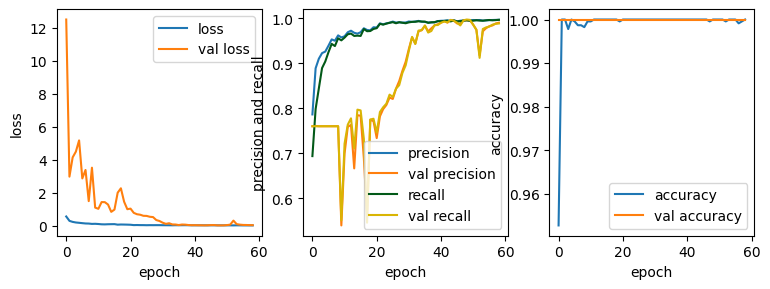

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[9, 3], dpi=100)
axes = axes.ravel()
epochs = list(range(len(history.history['loss'])))

sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[0],label='loss')
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[0],label='val loss')
sns.lineplot(x=epochs, y=history.history['precision_2'], ax=axes[1],label='precision')
sns.lineplot(x=epochs, y=history.history['val_precision_2'], ax=axes[1],label='val precision')
sns.lineplot(x=epochs, y=history.history['recall_2'], color='#025918', ax=axes[1],label='recall')
sns.lineplot(x=epochs, y=history.history['val_recall_2'], color='#D9B504',ax=axes[1],label='val recall')
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[2],label='accuracy')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[2],label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('precision and recall')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('accuracy')
plt.savefig('VGGNet_base_conv_train_history_with_cassava.png')
plt.show()

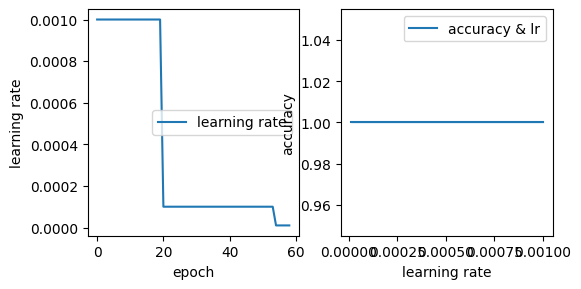

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[6, 3], dpi=100)
axes = axes.ravel()

sns.lineplot(x=epochs, y=history.history['lr'], ax=axes[0],label='learning rate')
sns.lineplot(x=history.history['lr'], y=history.history['val_accuracy'], ax=axes[1],label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('VGGNet_base_conv_lr_history_4.png')
plt.show()

NameError: ignored

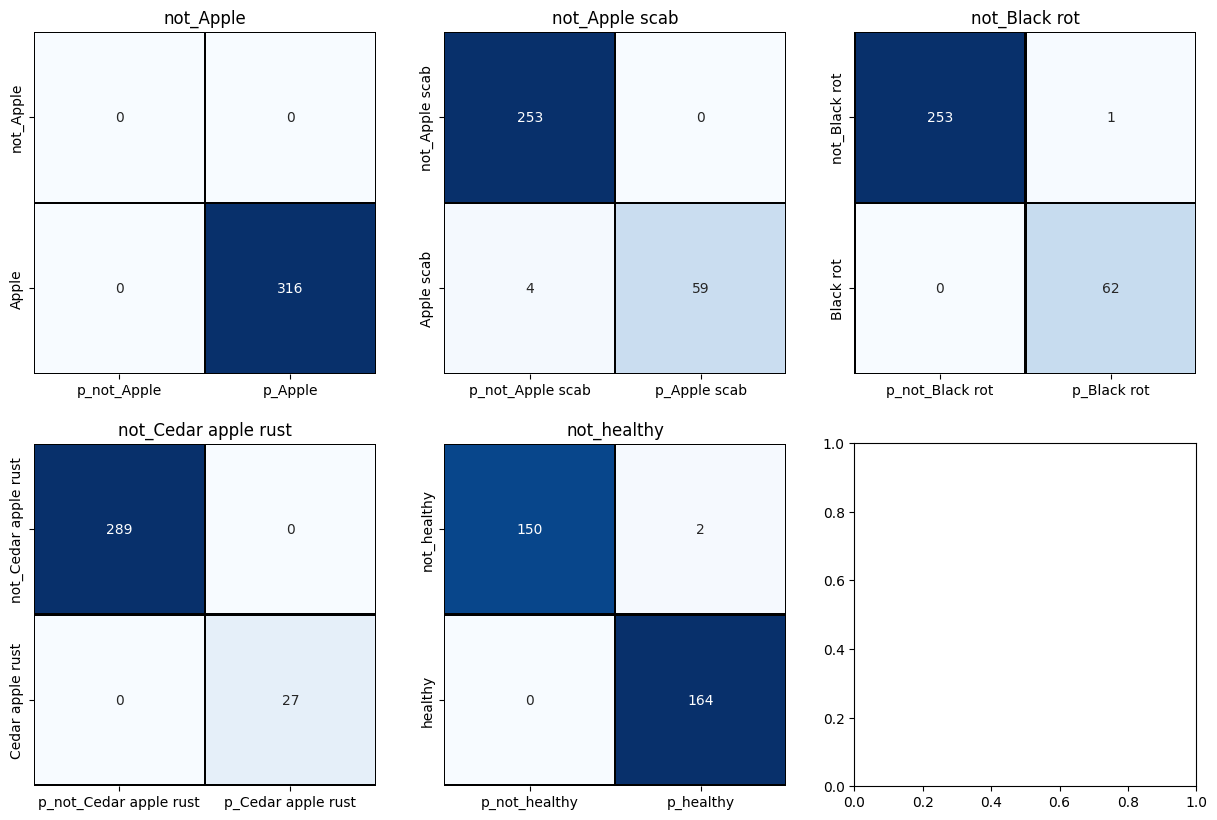

In [ ]:
# Plot confusion matrix
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], dpi=100)
axes = axes.ravel()

preds = np.where(exp_conv.predict(test_x) < 0.65, 0, 1)
confusion = multilabel_confusion_matrix(test_y, preds)

for i, (label, matrix) in enumerate(zip(mlb.classes_, confusion)):
    labels = [f'not_{label}', label]
    xlabels = [f'p_not_{label}', f'p_{label}']
    sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues',
                xticklabels=xlabels, yticklabels=labels, linecolor='black', linewidth=1,
                ax=axes[i])
    axes[i].set_title(labels[0])

plt.savefig('VGGNet_base_conv_4_cm.png')
plt.show()

In [ ]:
exp_conv.save('/content/drive/MyDrive/Applemodel.hdf5')

In [ ]:
mlb.classes_

array(['Apple', 'Apple scab', 'Black rot', 'Cedar apple rust', 'healthy'],
      dtype=object)

In [ ]:
exp_conv.predict(test_x[200:201])

array([[1.0000000e+00, 8.9192672e-06, 9.9999630e-01, 5.6649622e-08,
        3.0744147e-07]], dtype=float32)

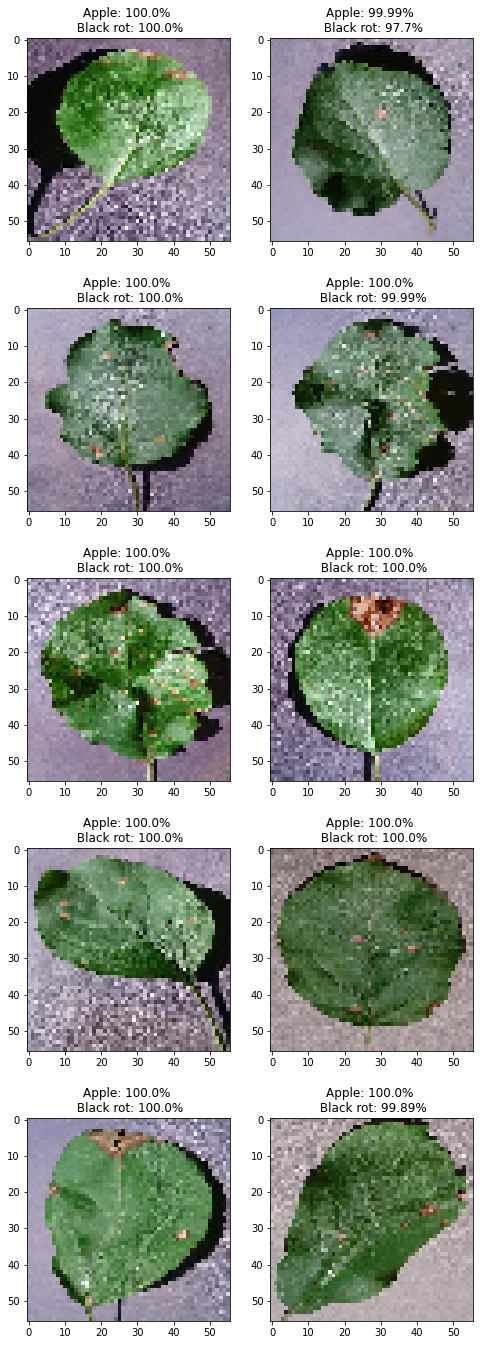

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize = (8, 24))
preds = exp_conv.predict(test_x[200:210])
axes = axes.ravel()

for i in range(len(preds)):
    p = zip(list(mlb.classes_), list(preds[i]))
    p = sorted(list(p), key = lambda z: z[1], reverse = True)[:2]
    axes[i].imshow(test_x[200+i])
    axes[i].set_title(f'{p[0][0]}: {round(p[0][1] * 100, 2)}% \n {p[1][0]}: {round(p[1][1] * 100, 2)}%')

In [ ]:
pd.to_pickle(pd.DataFrame(history.history), 'VGGNet_base_conv_lr_history.pkl')

In [4]:
model = load_model('/content/drive/MyDrive/b_Applemodel.hdf5')

In [89]:
img = load_img('/content/1234.jpeg',target_size=(56,56))

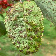

In [90]:
img

In [91]:
img_arr = img_to_array(img)

In [92]:
img_arr.shape

(56, 56, 3)

In [93]:
res_img_arr = np.reshape(img_arr,(1,56,56,3))
res_img_arr

array([[[[154., 112.,  88.],
         [139.,  88.,  67.],
         [118.,  45.,  30.],
         ...,
         [144., 118.,  91.],
         [ 97., 101.,  64.],
         [ 90.,  96.,  48.]],

        [[177.,  66.,  73.],
         [146.,  42.,  39.],
         [124.,  17.,   7.],
         ...,
         [157., 169., 129.],
         [156., 176., 115.],
         [164., 186., 114.]],

        [[176.,  69.,  63.],
         [127.,  42.,  22.],
         [130.,  53.,  27.],
         ...,
         [159., 192., 145.],
         [130., 154.,  94.],
         [165., 190., 122.]],

        ...,

        [[ 75., 114.,  25.],
         [ 76., 112.,  25.],
         [ 79., 112.,  31.],
         ...,
         [167., 161., 103.],
         [173., 152.,  97.],
         [191., 155., 105.]],

        [[ 72., 101.,  21.],
         [ 83., 111.,  34.],
         [ 88., 119.,  43.],
         ...,
         [193., 167., 110.],
         [181., 169., 109.],
         [157., 141.,  82.]],

        [[106., 125.,  59.],
       

In [99]:
pred = model.predict(res_img_arr)
pred

array([[1., 0., 0., 0., 1.]], dtype=float32)

In [103]:
pred[0][1:].argmax()

3

In [69]:
model.predict(X[0:1])

array([[1., 0., 0., 0., 1.]], dtype=float32)

In [80]:
X[0]

array([[[130., 122., 135.],
        [135., 127., 140.],
        [133., 125., 138.],
        ...,
        [177., 171., 185.],
        [156., 150., 164.],
        [162., 156., 170.]],

       [[149., 141., 154.],
        [141., 133., 146.],
        [131., 123., 136.],
        ...,
        [165., 159., 173.],
        [171., 165., 179.],
        [176., 170., 184.]],

       [[134., 126., 139.],
        [143., 135., 148.],
        [140., 132., 145.],
        ...,
        [174., 168., 182.],
        [173., 167., 181.],
        [176., 170., 184.]],

       ...,

       [[146., 136., 145.],
        [ 41.,  34.,  42.],
        [ 27.,  24.,  31.],
        ...,
        [192., 185., 193.],
        [195., 188., 196.],
        [196., 189., 197.]],

       [[ 33.,  28.,  35.],
        [ 30.,  25.,  32.],
        [ 33.,  26.,  34.],
        ...,
        [193., 186., 194.],
        [201., 194., 202.],
        [198., 191., 199.]],

       [[ 28.,  27.,  33.],
        [ 29.,  24.,  31.],
        [ 93.,  

In [74]:
X[0:1]

array([[[[130., 122., 135.],
         [135., 127., 140.],
         [133., 125., 138.],
         ...,
         [177., 171., 185.],
         [156., 150., 164.],
         [162., 156., 170.]],

        [[149., 141., 154.],
         [141., 133., 146.],
         [131., 123., 136.],
         ...,
         [165., 159., 173.],
         [171., 165., 179.],
         [176., 170., 184.]],

        [[134., 126., 139.],
         [143., 135., 148.],
         [140., 132., 145.],
         ...,
         [174., 168., 182.],
         [173., 167., 181.],
         [176., 170., 184.]],

        ...,

        [[146., 136., 145.],
         [ 41.,  34.,  42.],
         [ 27.,  24.,  31.],
         ...,
         [192., 185., 193.],
         [195., 188., 196.],
         [196., 189., 197.]],

        [[ 33.,  28.,  35.],
         [ 30.,  25.,  32.],
         [ 33.,  26.,  34.],
         ...,
         [193., 186., 194.],
         [201., 194., 202.],
         [198., 191., 199.]],

        [[ 28.,  27.,  33.],
       

In [2]:
def test(file_path):
  model = load_model('/content/drive/MyDrive/b_Applemodel.hdf5')
  img = load_img(file_path,target_size=(56,56))
  img_arr = img_to_array(img)
  res_img_arr = np.reshape(img_arr,(1,56,56,3))/255
  pred = model.predict(res_img_arr)
  return mlb.classes_[1:][pred[0][1:].argmax()], round(pred[0][pred[0][1:].argmax()+1]*100,2)

In [31]:
test('/content/car2.jpeg')

('Black rot', 99.93)